In [1]:
import numpy as np
import matplotlib.pyplot as plt
from data import load_training_data, load_test_data, split_data
import networkx as nx
import time, datetime
from utils import plot_graph

from n_walk import product_graph, graph_product, graph_product_el
import kernel_class as kc
import kernel_methods as km

from importlib import reload

In [2]:
graphs, labels =  load_training_data()
submi_graphs = load_test_data()

# Test of graph product

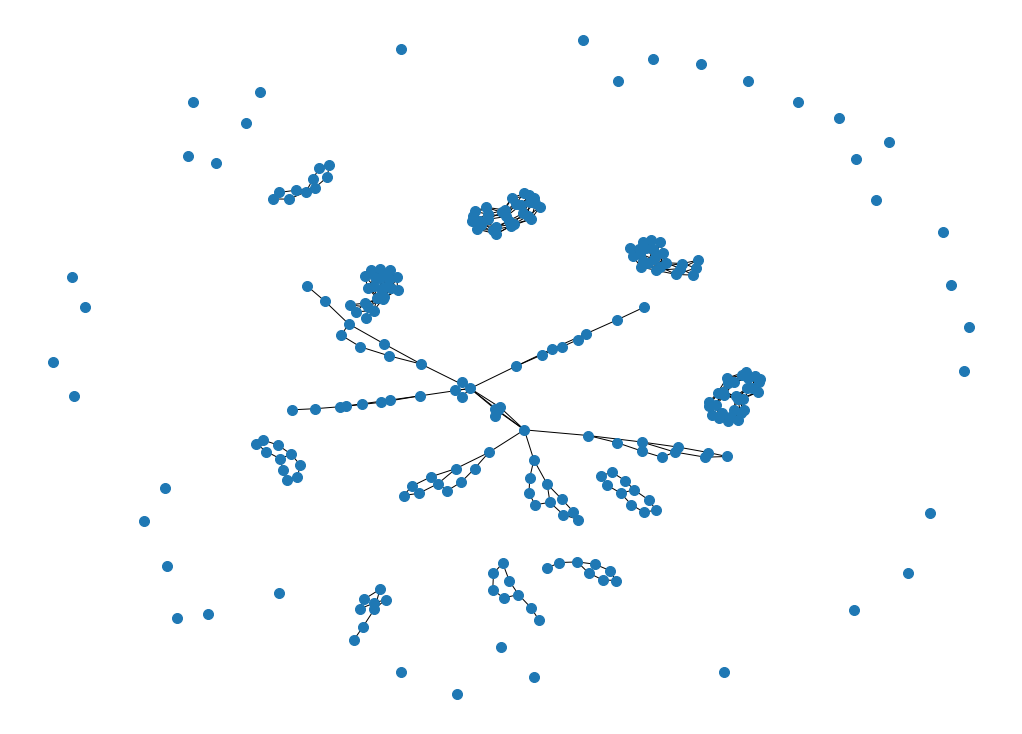

In [3]:
g1, g2 = graphs[:2]
plt.figure(figsize=(14, 10))
gp = product_graph(g1, g2)
nx.draw(gp, node_size = 100)

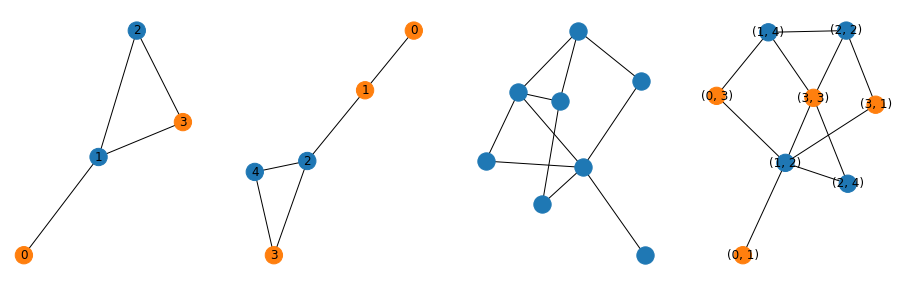

In [13]:
ga = nx.Graph([(0, 1), (1, 2), (1, 3), (2, 3)])
for v, l in zip(range(4), [0, 1, 1, 0]) : ga.nodes[v]["labels"] = [l]
gb = nx.Graph([(0, 1), (1, 2), (2, 3), (3, 4), (4, 2)])
for v, l in zip(range(5), [0, 0, 1, 0, 1]) : gb.nodes[v]["labels"] = [l]

plt.figure(figsize=(20, 5))
plt.subplot(1, 5, 1)
plot_graph(ga)
plt.subplot(1, 5, 2)
plot_graph(gb)
plt.subplot(1, 5, 3)
gp = product_graph(ga, gb)
initial_nodes = dict(gp.nodes)
for v in initial_nodes:
    if len(gp.edges(v))==0:
        gp.remove_node(v)
nx.draw(gp)
plt.subplot(1, 5, 4)
plot_graph(graph_product(ga, gb, with_lonely_nodes=False))

# Test product graph speed

In [14]:
np.random.seed(42)
g1_indices = np.random.choice(len(graphs), 6000, replace=True)
g2_indices = np.random.choice(len(graphs), 6000, replace=True)

def convert_time(seconds_tot):
    seconds = int(seconds_tot%60)
    minutes_tot = int(seconds_tot//60)
    if minutes_tot == 0: return f"{seconds}s"
    minutes = minutes_tot%60
    hours = int(minutes_tot//60)
    if hours == 0: return f"{minutes}m {seconds}s"
    return f"{hours}h {minutes}m {seconds}s"


def test_speed_one_graph(f, *args, **kwargs):
    n_in, n_out = 100, 60
    times_list = []
    for i in range(n_out):
        t0 = time.time()
        for j in range(n_in):
            g = graphs[g1_indices[i*n_in + j]]
            f(g, *args, **kwargs)
        t1 = time.time()
        times_list.append(t1 - t0)
    times_full = np.array(times_list)/n_in * (6000*6001)/2 #time to compute the whole gram matrix
    print(convert_time(times_full.mean()), ", ", convert_time(times_full.std()))
    return times_full

def test_speed_two_graphs(f, *args, **kwargs):
    n_in, n_out = 100, 60
    times_list = []
    for i in range(n_out):
        t0 = time.time()
        for j in range(n_in):
            g1 = graphs[g1_indices[i*n_in + j]]
            g2 = graphs[g2_indices[i*n_in + j]]
            f(g1, g2, *args, **kwargs)
        t1 = time.time()
        times_list.append(t1 - t0)
    times_full = np.array(times_list)/n_in * (6000*6001)/2 #time to compute the whole gram matrix
    print(convert_time(times_full.mean()), ", ", convert_time(times_full.std()))
    return times_full

In [20]:
from n_walk import product_graph, graph_product, graph_product_el
d = test_speed_two_graphs(product_graph)

19h 53m 43s ,  4h 4m 1s


In [21]:
d = test_speed_two_graphs(graph_product)

7h 57m 43s ,  2h 39m 12s


In [22]:
d = test_speed_two_graphs(graph_product, with_lonely_nodes=False)

5h 53m 40s ,  59m 27s


In [23]:
d = test_speed_two_graphs(graph_product_el)

8h 9m 12s ,  2h 54m 24s


In [24]:
d = test_speed_two_graphs(graph_product_el, with_lonely_nodes=False)

4h 41m 6s ,  1h 14m 44s


# Test of kernels

In [3]:
sub_graphs, sub_labels = split_data(graphs, labels)[0]

rwk = kc.RandomWalkKernel(0.95, False)

In [ ]:
ker = rwk.compute_gram_matrix(sub_graphs[:200])

In [14]:
np.where(ker ==ker.min())

(array([30, 39], dtype=int64), array([39, 30], dtype=int64))

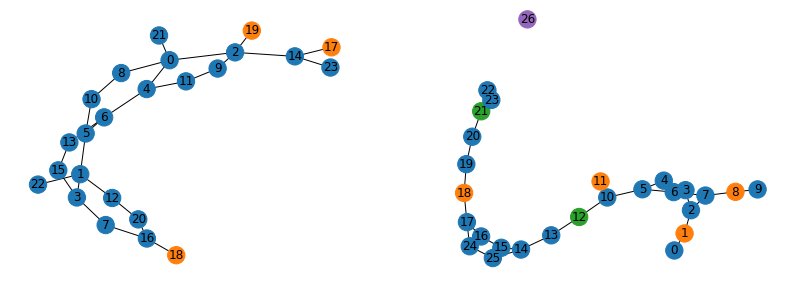

In [16]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plot_graph(sub_graphs[30])
plt.subplot(1, 2, 2)
plot_graph(sub_graphs[39])

In [16]:
ker_out = rwk.compute_outer_gram(sub_graphs[200:300], sub_graphs[:200])

100%|██████████| 100/100 [05:35<00:00,  3.35s/it]


In [ ]:
np.save("saved/rwkernel_200.npy", ker)
np.save("saved/rwkernel_outer_100_200.npy", ker_out)

In [4]:
ker = np.load("saved/rwkernel_200.npy")
ker_out = np.load("saved/rwkernel_outer_100_200.npy")

In [7]:
reload(km)
svm = km.KernelSVM()
svm.fit(None, sub_labels[:200], K=ker)

DCPError: Problem does not follow DCP rules. Specifically:
The objective is not DCP. Its following subexpressions are not:
QuadForm(var1, [[ 1.74402677  1.27118064 -0.67079119 ... -0.50128547 -0.65632418
  -0.55438933]
 [ 1.27118064  0.44714401 -1.22283812 ... -0.47020416 -0.5664794
  -0.44184859]
 [-0.67079119 -1.22283812 -0.52138984 ... -0.36840619 -0.30270115
  -0.54562839]
 ...
 [-0.50128547 -0.47020416 -0.36840619 ... -0.308761   -0.49583057
   4.31645859]
 [-0.65632418 -0.5664794  -0.30270115 ... -0.49583057 -0.25219957
  -0.65500657]
 [-0.55438933 -0.44184859 -0.54562839 ...  4.31645859 -0.65500657
  -0.43003897]])

In [41]:
reload(kc)
rwk = kc.RandomWalkKernel(0.5, with_lonely_nodes=False)
little_ker = rwk.compute_gram_matrix(sub_graphs[:10])

100%|██████████| 10/10 [00:01<00:00,  5.59it/s]


In [42]:
little_ker

array([[2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2.]])

In [45]:
from grakel import RandomWalkLabeled, RandomWalk

In [109]:
rwgk = RandomWalkLabeled(lamda=0.99, method_type='baseline')
gs = [nx.adjacency_matrix(g).toarray() for g in sub_graphs[:10]]
nls = [[x[0] for x in nx.get_node_attributes(g, "labels").values()] for g in sub_graphs[:10]]

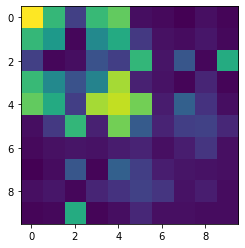

In [111]:
plt.imshow(rwgk.fit_transform(zip(gs, nls)))

In [115]:
mlkj = rwgk.fit_transform(zip(gs, nls))

dict_keys([(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)])

In [ ]:
little_ker

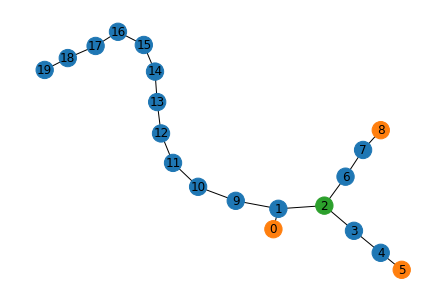

In [61]:
plot_graph(sub_graphs[3])

In [29]:
w, v = np.linalg.eig(inv)
w[:2].dot((v.sum(axis=0)**2)[:2])
w[:2], v[:,:2].sum(axis=0), v[:,:2].sum(axis=0)**2, w[:2].dot((v[:,:2].sum(axis=0)**2))

(array([100.+0.j, 100.+0.j]),
 array([-4.79583152+0.j,  4.69353643+0.j]),
 array([23.        -0.j, 22.02928421+0.j]),
 (4502.928420942568+0j))

In [86]:
g1 = sub_graphs[0]
g2 = sub_graphs[1]
g_prod = graph_product(g1, g2, with_lonely_nodes=False)
A = nx.adjacency_matrix(g_prod).toarray()
degrees = np.sum(A, axis=1, keepdims=True)
W = A/np.where(degrees==0, 1, degrees)
ImW_inv = np.linalg.inv(np.eye(len(g_prod)) - 0.99 * W)
# p_init = np.ones((len(g_prod)))/len(g_prod)
# k_result = p_init@ImW_inv@np.ones((len(g_prod)))
k_result = np.sum(ImW_inv) / len(g_prod)
print(k_result)

99.9999999999996


In [121]:
from n_walk import get_labels_nodes
from itertools import product
g1 = sub_graphs[3]
g2 = sub_graphs[7]
lab1 = np.array(get_labels_nodes(g1))
lab2 = np.array(get_labels_nodes(g2))
A1 = nx.adjacency_matrix(g1).toarray()
A2 = nx.adjacency_matrix(g2).toarray()
common_labels = set(lab1) & (set(lab2))
XY = np.zeros((A1.shape[0]*A2.shape[0], A1.shape[0]*A2.shape[0]))
for t in product(common_labels, common_labels):
    adj_sel1 = (lab1 == t[0])[:,None]*A1*(lab1 == t[1])[None,:]
    adj_sel2 = (lab2 == t[0])[:,None]*A2*(lab2 == t[1])[None,:]
    # print(np.all(adj_sel1 == rwgk.X[0][0][t]), np.all(adj_sel2 == rwgk.X[1][0][t]))
    XY += np.kron(adj_sel1, adj_sel2)
np.linalg.inv(np.eye(XY.shape[0]) - 0.99*XY).sum()

-1.6753492615357521

In [122]:
mlkj[3, 7]

-1.6753492615357521